In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install tensorflow matplotlib pillow

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers


In [5]:
os.listdir("/content/drive/MyDrive/anime_gan_project/anime_gan_project/dataset/images")[:10]


['1224_2001.jpg',
 '12144_2005.jpg',
 '12193_2005.jpg',
 '1219_2001.jpg',
 '12164_2005.jpg',
 '12143_2005.jpg',
 '12213_2005.jpg',
 '12183_2005.jpg',
 '12165_2005.jpg',
 '12153_2005.jpg']

In [6]:
IMG_SIZE = 64
BATCH_SIZE = 32
LIMIT = 2000  # optional: train faster

def load_images(folder, limit=None):
    images = []
    files = os.listdir(folder)
    if limit:
        files = files[:limit]
    for file in files:
        img = Image.open(os.path.join(folder, file)).convert("RGB")
        img = img.resize((IMG_SIZE, IMG_SIZE))
        images.append(np.array(img))
    return np.array(images)

images = load_images("/content//drive/MyDrive/anime_gan_project/anime_gan_project/dataset/images", LIMIT)
images = (images - 127.5) / 127.5

print("Loaded images:", images.shape)


Loaded images: (2000, 64, 64, 3)


In [7]:
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(images.shape[0]).batch(BATCH_SIZE)


In [8]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=[64,64,3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [11]:
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))


In [12]:
EPOCHS = 20  # increase for better results

for epoch in range(EPOCHS):
    for image_batch in dataset:
        train_step(image_batch)
    print(f"Epoch {epoch+1}/{EPOCHS} completed")


Epoch 1/20 completed
Epoch 2/20 completed
Epoch 3/20 completed
Epoch 4/20 completed
Epoch 5/20 completed
Epoch 6/20 completed
Epoch 7/20 completed
Epoch 8/20 completed
Epoch 9/20 completed
Epoch 10/20 completed
Epoch 11/20 completed
Epoch 12/20 completed
Epoch 13/20 completed
Epoch 14/20 completed
Epoch 15/20 completed
Epoch 16/20 completed
Epoch 17/20 completed
Epoch 18/20 completed
Epoch 19/20 completed
Epoch 20/20 completed


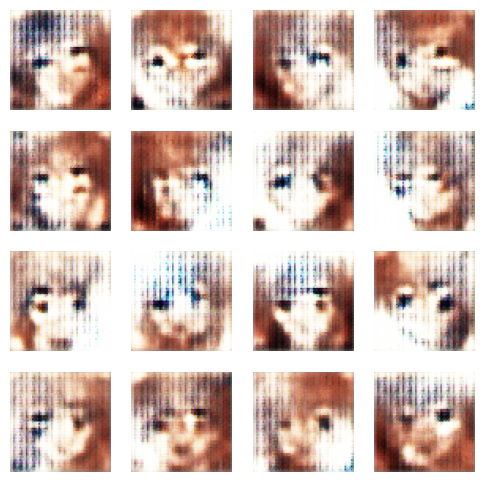

In [13]:
def generate_and_show():
    noise = tf.random.normal([16, noise_dim])
    generated_images = generator(noise, training=False)

    plt.figure(figsize=(6,6))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow((generated_images[i] + 1)/2)
        plt.axis('off')
    plt.show()

generate_and_show()
